<a href="https://colab.research.google.com/github/deexth/Pyt/blob/master/chpt3_hml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [78]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.datasets import fetch_openml
from sklearn.model_selection import (
    cross_val_predict,
    cross_val_score,
    cross_validate,
    StratifiedKFold,
)
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
from pathlib import Path
import numpy as np


set_config(display="diagram")

Just like in the previous chapter, let's define the default font sizes to make the figures prettier:


In [2]:
plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

And let's create the `images/classification` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:


In [3]:
IMAGE_PATH = Path() / "images" / "classification"
IMAGE_PATH.mkdir(parents=True, exist_ok=True)


def save_fig(fig_id: str, tight_layout=True, fig_etension="png", resolution=300):
    path = IMAGE_PATH / f"{fig_id}.{fig_etension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_etension, dpi=resolution)

# MNIST


In [4]:
mnist = fetch_openml("mnist_784", as_frame=False)
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [86]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [87]:
x, y = mnist.data, mnist.target

In [88]:
x.shape, y.shape

((70000, 784), (70000,))

Function to plot the image


In [89]:
def plot_image(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

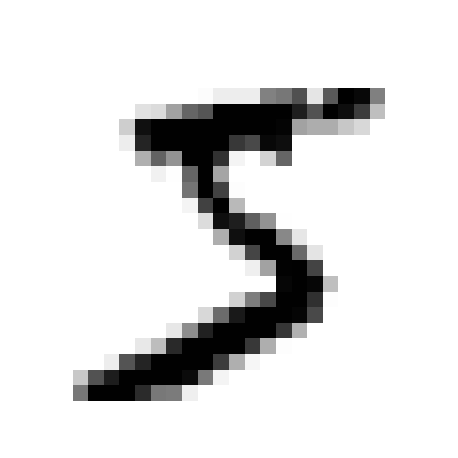

In [90]:
some_digit = x[0]
plot_image(some_digit)
save_fig("some_digit")
plt.show()

Plot the first 100 images in the training data


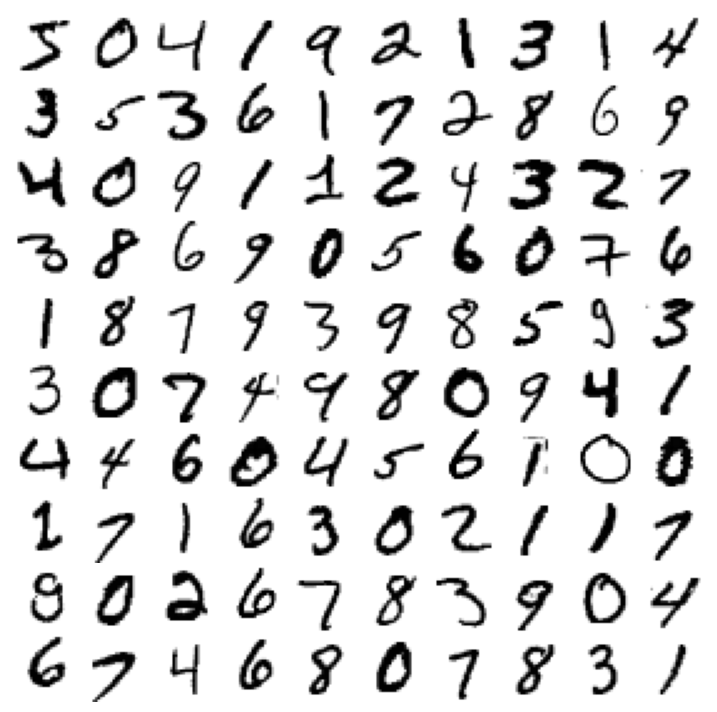

In [91]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(x[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_image(image_data)

plt.subplots_adjust(wspace=0, hspace=0)
save_fig("first100images", tight_layout=False)
plt.show()

In [92]:
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

# Trainig a binary classifier


In [12]:
y_train_5 = y_train == "5"
y_test_5 = y_test == "5"

In [13]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)


SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

# Perfomance measure


## Measuring accuracy using cross-validation


In [15]:
cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [16]:
skfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if not already shuffled

split = 0
for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_folds = x_train[test_index]
    y_test_folds = y_train_5[test_index]

    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    n_correct = n_correct / len(y_pred)
    split += 1
    print(f"split {split}: {n_correct}")

split 1: 0.95035
split 2: 0.96035
split 3: 0.9604


In [17]:
dummy_clf = DummyClassifier()
dummy_clf.fit(x_train, y_train_5)
print(any(dummy_clf.predict(x_train)))

False


In [18]:
cross_val_score(dummy_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

## Confusion matrix


In [19]:
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

In [20]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [21]:
y_train_Pred_perfection = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_Pred_perfection)

array([[54579,     0],
       [    0,  5421]])

## Precision and Recall


In [22]:
precision_score(y_train_5, y_train_pred) # == 3530 / (687 + 3530)

0.8370879772350012

In [23]:
# extra code – this cell also computes the precision: TP / (FP + TP)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [24]:
recall_score(y_train_5, y_train_pred) # == 3530 / (1891 + 3530)

0.6511713705958311

In [25]:
# extra code – this cell also computes the recall: TP / (FN + TP)
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

In [26]:
f1_score(y_train_5, y_train_pred) # == 3530 / (3530 + ((687 + 1891) / 2)) )

0.7325171197343847

In [27]:
# extra code – this cell also computes the f1 score
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

## Precision/Recall trade-off

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [29]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [30]:
y_some_digit_pred

array([ True])

In [31]:
# extra code – just shows that y_scores > 0 produces the same result as
#              calling predict()
y_scores > 0

array([ True])

In [32]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred


array([False])

In [33]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [34]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [35]:
precisions, recalls, thresholds

(array([0.09035   , 0.09035151, 0.09035301, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        3.68935621e-04, 1.84467810e-04, 0.00000000e+00]),
 array([-146348.56726174, -142300.00705404, -137588.97581744, ...,
          38871.26391927,   42216.05562787,   49441.43765905]))

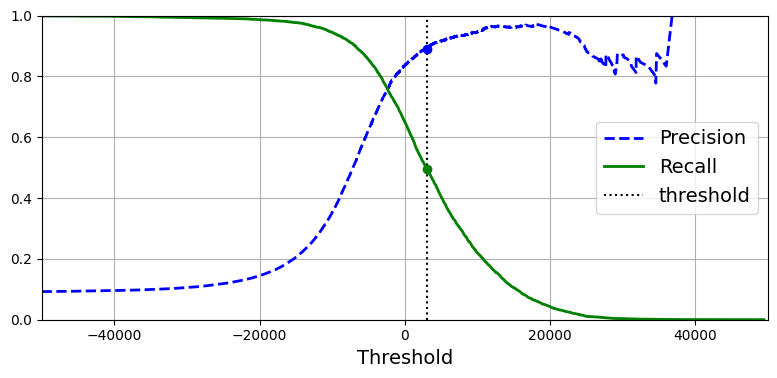

In [40]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

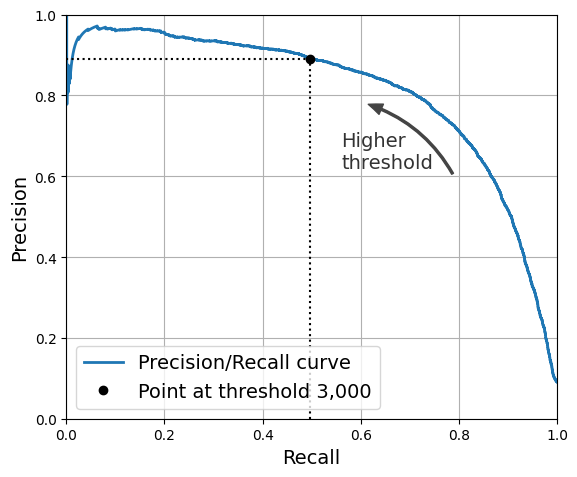

In [41]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

In [36]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [37]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [38]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [39]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

## ROC curve

In [42]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

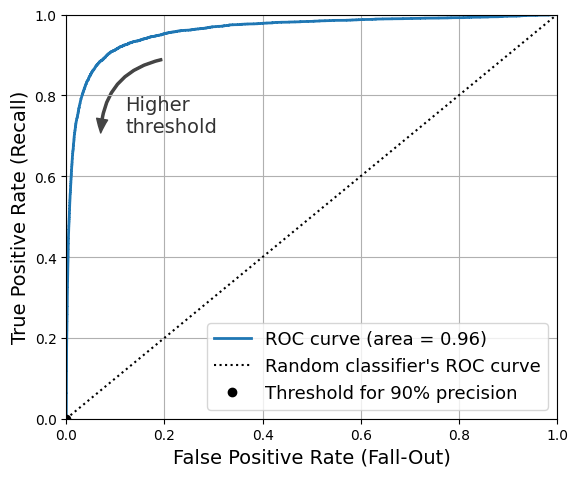

In [45]:
idx_for_threshold_at_90 = (thresholds >= threshold_for_90_precision).argmax()
tpr_90, fpr_90, = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, label="ROC curve (area = {:.2f})".format(roc_auc_score(y_train_5, y_scores)))
plt.plot([0, 1], [0, 1], "k:", label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code - just beautifies and saves figure 3-7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

In [46]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [47]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method="predict_proba")


In [49]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

These are *estimated probabilities*. Among the images that the model classified as positive with a probability between 50% and 60%, there are actually about 94% positive images:

In [51]:
# Not in the code
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

94.0%


In [52]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

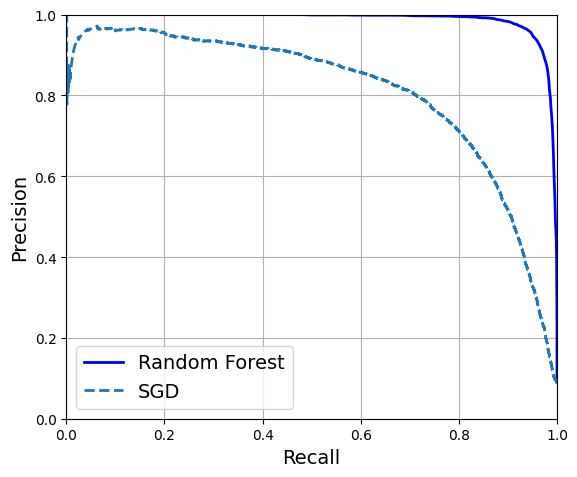

In [53]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

We could use `cross_val_predict(forest_clf, X_train, y_train_5, cv=3)` to compute `y_train_pred_forest`, but since we already have the estimated probabilities, we can just use the default threshold of 50% probability to get the same predictions much faster:

In [55]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5 # positive proba >=50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [57]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [58]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [59]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

# Multiclass Classification

SVMs do not scale well to large datasets, so let's only train on the first 2,000 instances, or else this section will take a very long time to run:

In [60]:
svm_clf = SVC(random_state=42)
svm_clf.fit(x_train[:2000], y_train[:2000])
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [62]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [63]:
class_id = some_digit_scores.argmax()
class_id

5

In [64]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [65]:
svm_clf.classes_[class_id]

'5'

If you want `decision_function()` to return all 45 scores, you can set the `decision_function_shape` hyperparameter to `"ovo"`. The default value is `"ovr"`, but don't let this confuse you: `SVC` always uses OvO for training. This hyperparameter only affects whether or not the 45 scores get aggregated or not:

In [66]:
# extra code - shows how to get all 45 OvO scores if needed
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

In [68]:
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(x_train[:2000], y_train[:2000])
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [70]:
len(ovr_clf.estimators_)

10

In [71]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [76]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [73]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [75]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")


array([0.8983, 0.891 , 0.9018])

# Error Analysis

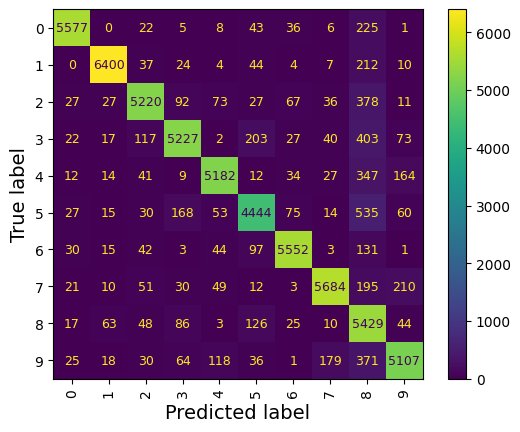

In [79]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
plt.rc("font", size=9) # extra code - make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, xticks_rotation="vertical")
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

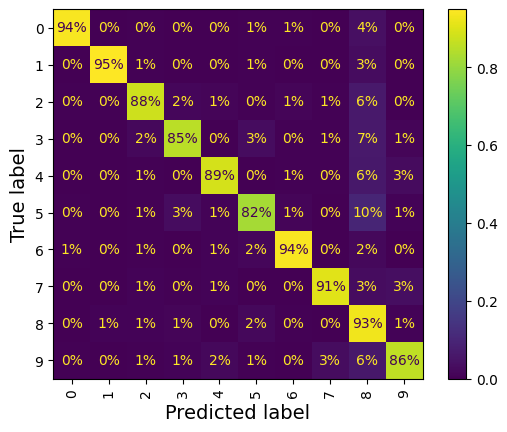

In [80]:
plt.rc("font", size=10) # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%", xticks_rotation="vertical")
save_fig("confusion_matrix_normalized", tight_layout=False)
plt.show()

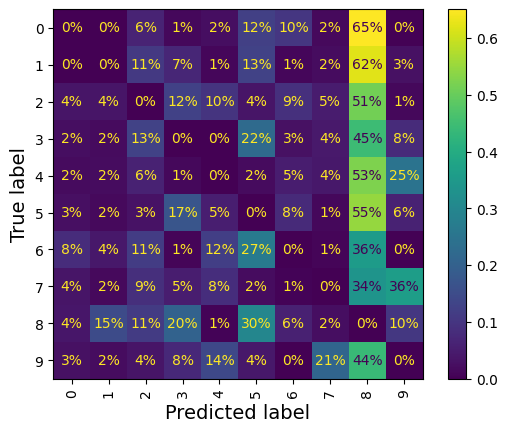

In [82]:
sample_weight = (y_train_pred != y_train)
plt.rc("font", size=10) # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="true", values_format=".0%", xticks_rotation="vertical")
plt.show()

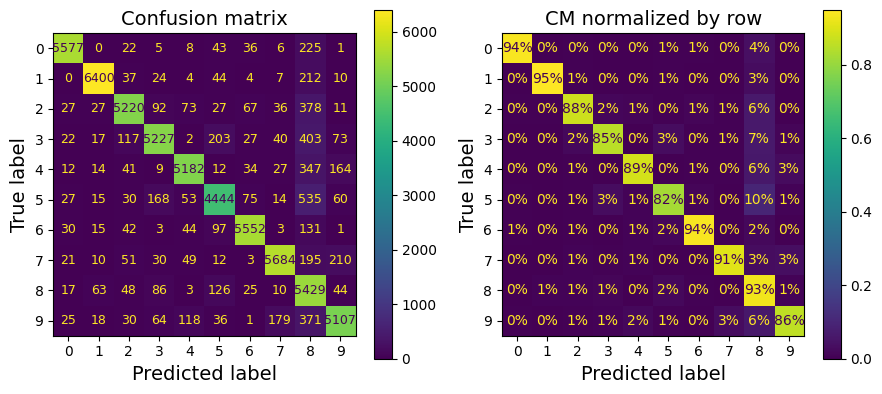

In [83]:
# extra code – this cell generates and saves Figure 3–9
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        normalize="true", values_format=".0%")
axs[1].set_title("CM normalized by row")
save_fig("confusion_matrix_plot_1")
plt.show()

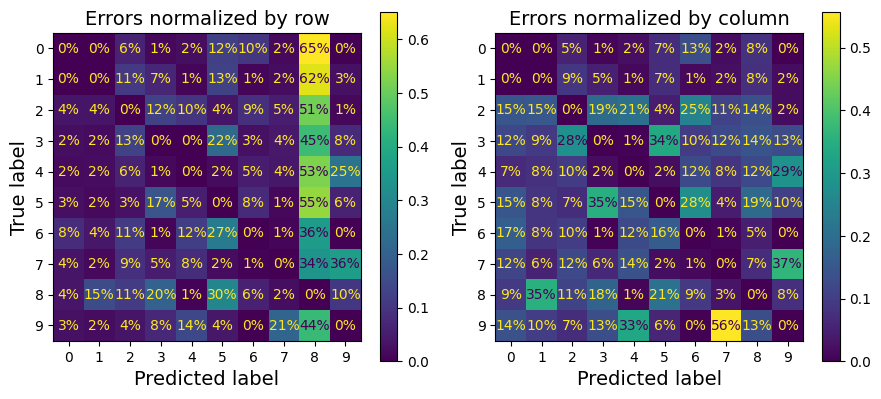

In [84]:
# extra code – this cell generates and saves Figure 3–10
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized by column")
save_fig("confusion_matrix_plot_2")
plt.show()
plt.rc('font', size=14)  # make fonts great again

In [95]:
cl_a, cl_b = '3', '5'
X_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]


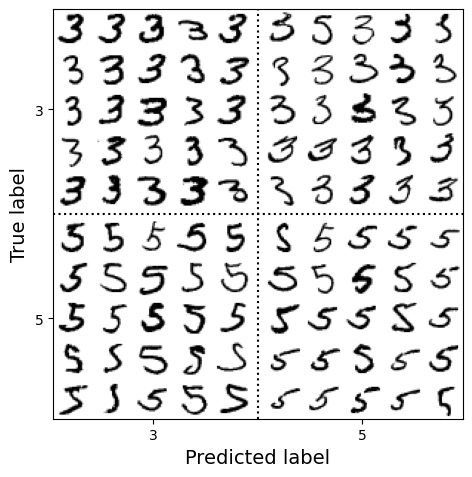

In [96]:
# extra code – this cell generates and saves Figure 3–11
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
save_fig("error_analysis_digits_plot")
plt.show()

# Multilabel Classification